<a href="https://colab.research.google.com/github/LuisMachadoSaa/Briefcase_project/blob/main/Proyecto_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# Context

La propagación de *fake news* o noticias falsas se incrementó a partir de la pandemia por COVID-19. Estas son un problema alarmante porque hacen que las personas realicen actividades que normalmente no llevarían a cabo o que actúen de manera caótica. Un ejemplo es [-> esta noticia <-](https://drive.google.com/file/d/1PrfN83Fm1ib5mHYN6SULVe9CJVECUNn2/view?usp=share_link), en la que se relata cómo notas falsas acerca del daño que ocasiona la 5G al cuerpo provocaron que muchas personas en el Reino Unido quemaran torres de telecomunicaciones aun sin ser estas de 5G.

A ti, como persona experta en redes neuronales, te han encargado hacer un predetector de noticias falsas para los *fact-checker* del mundo.

Para realizarlo, tienes a tu disposición el siguiente *dataset*: https://www.kaggle.com/datasets/saurabhshahane/fake-news-classification


- Prueba tu modelo con esta noticia falsa: https://www.breitbart.com/politics/2016/09/10/exposed-fbi-director-james-comeys-clinton-foundation-connection/
- Prueba tu modelo con esta noticia verdadera: https://www.washingtonpost.com/sports/2022/11/14/world-cup-female-referee-kathryn-nesbitt/



## Importing Libraries

In [ ]:
from tensorflow.keras import datasets
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Dropout,
                                     Dense,
                                     SimpleRNN,
                                     LSTM,
                                     Conv2D,
                                     Embedding,
                                     MaxPooling2D,
                                     Flatten,
)
from tensorflow.keras import optimizers
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

In [ ]:
import numpy as np
from pandas import (read_csv,
                    DataFrame,
)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
from seaborn import countplot, heatmap

In [ ]:
from PIL import Image

In [ ]:
import requests

In [ ]:
from bs4 import BeautifulSoup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load Dataset

In [ ]:
df = read_csv('/content/drive/MyDrive/Colab Notebooks/proyectos/WELFake_Dataset.csv')
df.head()

,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,1,NaN,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


Cargamos el dataset que usaremos para el entrenamiento de nuetro modelo, y lo definimos como *df*


##EDA

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72134 entries, 0 to 72133
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  72134 non-null  int64 
 1   title       71576 non-null  object
 2   text        72095 non-null  object
 3   label       72134 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 2.2+ MB


Mostramos la información general del dataset; Se muestran los tipos de datos de cada columna, el total de muestras por columna y la existencia de valores nulos. Podemos ver la primera columna la cual no nos serviria para nada, ya que seria como un identificador numerico de cada uno de los valores.

In [ ]:
df.duplicated().sum()

0

Acá podremos observar la sumatoria de todos los valores duplicados del dataset, de no existir algun valor duplicado nos imprime un 0

In [ ]:
df.isnull().sum()

Unnamed: 0      0
title         558
text           39
label           0
dtype: int64

In [ ]:
print(df.isnull().sum() / len(df)*100)

Unnamed: 0    0.000000
title         0.773560
text          0.054066
label         0.000000
dtype: float64


Mostramos los valores faltantes de las columnas a trabajar, podemos observar que hay datos faltantes, pero es tan minimo que serian irrelevantes para el dataset

<div class="alert alert-info" role="alert">
<ul>
<li> En términos generales, se suelen considerar los siguientes grados de impacto, dependiendo del porcentaje de valores faltantes (dumb rules):

- Menos de 1%: Trivial (no relevante)
- 1-5%: Manejable
- 5-15%: Manejable mediante métodos sofisticados
- Más de 15%: Crítico, con impacto severo en cualquier tipo de interpretación
    
</div>

## Data Preprocessing

In [ ]:
df.drop(columns=['Unnamed: 0'], inplace=True)

Acá borramos dicha columna que no usaremos

In [ ]:
df.dropna(inplace=True)

In [ ]:
df = df.reset_index(drop=True)

Eliminamos los valores faltantes, y reestablecemos los indices del dataframe

## Univariate Analysis

<Axes: ylabel='label'>

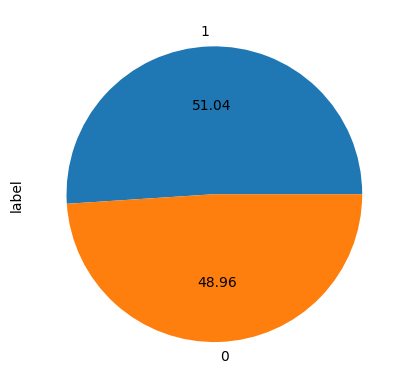

In [ ]:
df['label'].value_counts().plot.pie(autopct='%.2f')

In [ ]:
df['label'].value_counts()

1    36509
0    35028
Name: label, dtype: int64

Mediante la grafica pie o pastel, observamos que la columna *label* que contiene si la notica es falsa o verdadera, esta muy equilibrada bastante parejo

## Train and test data

In [ ]:
X = df['text']
y = df['label']

# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

Antes de llevar acabo la tokenización, definimos nuestras variables *X* y *y*, en este caso usare solo la columna *text* para entrenar mi modelo, la columna *title* no creo que aporte al modelo, al ser un *clickbait* aportaria datos erroneos al modelo.

##Tokenization

In [ ]:
# Definir el TextVectorization con salida de enteros
text_vectorizer = TextVectorization(max_tokens=10000,
                                    output_mode='int', # El tipo de salida
                                    standardize='lower', # Optimizador
                                    output_sequence_length=500, # Longitud de salida
                                    pad_to_max_tokens=500,
                                    )
text_vectorizer.adapt(X_train)
X_train = text_vectorizer(X_train)
X_test = text_vectorizer(X_test)


Definimos una variable con el *TextVectorization* para transformar el texto y poder trabajar los datos, le aplicamos unos cuantos hiperparametros para mejorar la salida de los datos.

Adaptamos con la variable *X_train* y luego vectorizamos sobreescribiendo las variables de conjunto *X*

## Define the Neural Network

In [ ]:
# Definir el modelo
model = Sequential()

model.add(Embedding(10000, 128, input_length=500))


model.add(LSTM(128))

# Agregar una capa densa final con activación sigmoid para la clasificación binaria
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 128)          1280000   
                                                                 
 lstm (LSTM)                 (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1411713 (5.39 MB)
Trainable params: 1411713 (5.39 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Definimos nuestro modelo, en este caso utilizando la arquitectura sequential en Keras, consta de una capa de embedding(128 dim con vocabulario de 10.000) para convertir los números enteros en vectores de embeddings, seguida de una capa LSTM(128Unidades) para modelar las dependencias temporales en los datos de secuencia, y finalmente una capa densa con activación sigmoidal para la clasificación binaria.

## Compile the model

In [ ]:
# Compilamos el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Compilamos el modelo especificando la función de pérdida y el optimizador, este caso con *binary_crossentropy* y *adam*, con la metrica de desempeño *accuracy*

## Train the model

In [ ]:
# Entrenamos el modelo
history = model.fit(X_train, y_train, epochs=3, batch_size=42)

Epoch 1/3
1363/1363 [==============================] - 87s 61ms/step - loss: 0.5365 - accuracy: 0.7056
Epoch 2/3
1363/1363 [==============================] - 39s 29ms/step - loss: 0.1237 - accuracy: 0.9578
Epoch 3/3
1363/1363 [==============================] - 32s 23ms/step - loss: 0.0371 - accuracy: 0.9887


Entrenamos nuestro modelo el cual definimos como *history*, y lo haremos con 3 epocas en este caso. En la sección de evaluación del modelo lo explicare.

## Evaluate the model

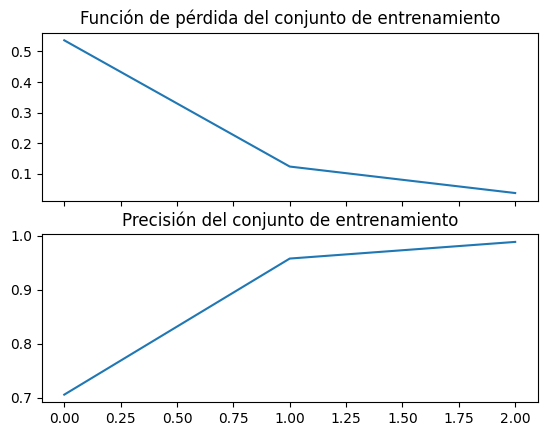

In [ ]:
fig = plt.figure()
ax1 = fig.add_subplot(2,1,1)
ax1.plot(history.history['loss'])
ax1.set_title('Función de pérdida del conjunto de entrenamiento')
ax2 = fig.add_subplot(2,1,2, sharex= ax1)
ax2.plot(history.history['accuracy'])
ax2.set_title('Precisión del conjunto de entrenamiento')

plt.setp(ax1.get_xticklabels(), visible=False)

plt.show()

Graficamos la función de perdida y la precisión del modelo conforme avanza de epocas en el entrenamiento. Ya en la epoca 2 se consiguio el 95% de precisión con una perdida de información del 12%, a la epoca 3 era suficiente para el entrenamiento cuidando los recursos disponibles

In [ ]:
# Evaluar el modelo en el conjunto de prueba
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

448/448 [==============================] - 4s 8ms/step - loss: 0.0447 - accuracy: 0.9848
Loss: 0.04466693475842476, Accuracy: 0.9848336577415466


Evaluamos nuestro modelo con las metricas de precisión y función de perdida. Nos arroja una perdida de información de un casí 4% y una precisión del 98%

## Predict test data

In [ ]:
predicciones = model.predict(X_test)
print(predicciones)

448/448 [==============================] - 4s 7ms/step
[[9.9916887e-01]
 [4.8479729e-04]
 [2.8683492e-03]
 ...
 [9.9893659e-01]
 [3.7822025e-03]
 [9.9452496e-01]]


Aplicamos un *predict* con nuestro modelo al conjunto de prueba *X_test*, y lo definimos como *predicciones*

In [ ]:
predicciones_flat = predicciones.flatten()
predic_si = DataFrame({'Real': y_test,
                     'Predicción': predicciones_flat})
predic_si.head(10)

,Real,Predicción
53925,1,0.999169
6939,0,0.000485
28713,0,0.002868
65420,1,0.996083
2286,0,0.001370
34184,1,0.998988
29103,1,0.994738
26688,0,0.001819
42956,1,0.958652
65156,1,0.999581


Les mostrare una comparación con los datos reales frente a los predichos, para poder mostrarlo en un dataframe, aplane las muestras para poder trabajarlas en un dataframe

In [ ]:
umbral = 0.5  # Umbral de decisión para la clasificación binaria
predicciones_binarias = np.where(predicciones >= umbral, 1, 0)

# Calcular la matriz de confusión
cm = confusion_matrix(y_test, predicciones_binarias)

Para lograr graficar nuestra matriz de confusión y observar el desempeño, ambas varibles deben ser de valor *0* o *1*, es decir, es un problema de clasificación binaria. Definimos una variable con un umbrar definido, de manera que los "rendondee" a *0* o *1*

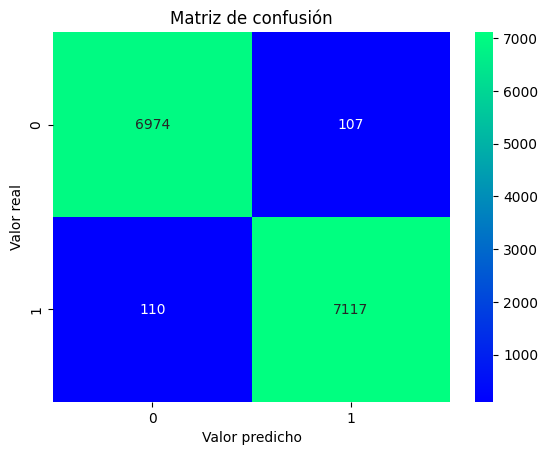

In [ ]:
heatmap(cm, annot= True, fmt= '.0f', cmap= 'winter')
plt.title('Matriz de confusión')
plt.xlabel('Valor predicho')
plt.ylabel('Valor real')
plt.show()

Graficamos el desempeño del modelo con esta matriz de confusión la cual nos arroja un buen desempeño, ya que ha acertado en su gran mayoria a los *True positive * y *True negative*

Ya con nuestro modelo listo, lo usaremos para corroborar si las siguientes noticias son falsas o verdaderas.

#Parse a fakenew

## Load Data

## HTLM extraction

In [ ]:
url = "https://www.breitbart.com/politics/2016/09/10/exposed-fbi-director-james-comeys-clinton-foundation-connection/"

Definimos una variable con la dirección de la pagina web donde proviene la noticia

In [ ]:
response = requests.get(url)
if response.status_code != 200:
    raise Exception("URL was not found")

text = response.text

Acá sacamos toda la información de la pagina web, en caso de ser una dirección erronea, me arrojaria una advertencia

In [ ]:
display(text)

'<!DOCTYPE html>\n<html lang="en" prefix="og: http://ogp.me/ns# fb: http://ogp.me/ns/fb# op: http://media.facebook.com/op# article: http://ogp.me/ns/article#" class="post-tmpl-default single single-post pid-4957476 tf-single pt-post c-politics">\n<head>\n\t<meta charset="utf-8">\n\t<meta name="viewport" content="width=device-width,initial-scale=1">\n\n\t<link rel="dns-prefetch" href="https://geolocation.onetrust.com">\n\t<link rel="preconnect" href="https://geolocation.onetrust.com">\n\n\t<link rel="preload" href="https://cdn.cookielaw.org/scripttemplates/otSDKStub.js" as="script">\n\t<link rel="preload" href="https://cdn.cookielaw.org/consent/bea5fecf-7066-4a7e-ad83-51130a031a8a/bea5fecf-7066-4a7e-ad83-51130a031a8a.json" type="application/json" as="fetch" crossorigin>\n\n\n\t<link rel="dns-prefetch" href="https://fonts.gstatic.com" crossorigin>\n\t<link rel="preconnect" href="https://fonts.gstatic.com" crossorigin>\n\n\t<link rel="preload" href="https://fonts.googleapis.com/css2?famil

Así se ve la noticia antes del pre-procesamiento

## Text Processing

In [ ]:
soup = BeautifulSoup(text, "html.parser")

In [ ]:
main = soup.find(id="MainW")

paragraphs = main.findAll("p")

content = ""
for paragraph in paragraphs:
    content = content + paragraph.get_text()

texto_lista = [content]

Acá definimos una variable con la extracción del texto del HTLM, luego iteramos por parrafos y seleccionado con el *id* especificamente la noticia y todo almacenandolo en la variable *texto lista*. Para aplicarle la tokenización tuve que hacerla lista, por eso lo de la linea 9.

In [ ]:
print(texto_lista)

["WASHINGTON, D.C. — A review of FBI Director James Comey’s professional history and relationships shows that the Obama cabinet leader — now under fire for his handling of the investigation of Hillary Clinton — is deeply entrenched in the big-money cronyism culture of Washington, D.C. His\xa0personal and professional relationships — all undisclosed as he announced the Bureau would not\xa0prosecute Clinton — reinforce bipartisan concerns that he\xa0may have politicized the criminal probe.These concerns focus on millions of dollars that Comey accepted from a Clinton Foundation defense contractor, Comey’s former membership on a Clinton Foundation corporate partner’s board, and his surprising financial relationship with his brother Peter Comey, who works at the law firm that does the Clinton Foundation’s taxes.Lockheed MartinWhen President Obama nominated Comey to become FBI director in 2013, Comey promised the United States Senate that he would recuse himself on all cases involving former

Ahora va tomando mejor forma, así se  ve luego de pre-procesamiento de texto.

## Tokenization

In [ ]:
new_vocab_size = 597
new_text_vectorizer = TextVectorization(max_tokens=new_vocab_size,
                                        standardize='lower',
                                        output_mode='int',
                                        output_sequence_length=500, # Longitud de salida
                                        pad_to_max_tokens=500,
                                        )

new_text_vectorizer.adapt(texto_lista)
vectorized_text_fake = new_text_vectorizer(texto_lista)

Tokenizamos el texto de la noticia, modifique unos hiperparametros como el maximo de tokens colocandole exacto al texto, del resto los mismos al que use en el modelo.

In [ ]:
vectorized_text_fake

<tf.Tensor: shape=(1, 500), dtype=int64, numpy=
array([[ 52,  71,  34,   5, 268,   7,  22,  25,  15,  26, 101, 410,   6,
         95, 246,   9,   2,  36, 542, 379,  34, 335,  85, 441,  10,  14,
        126,   7,   2, 120,   7,  46,  11,  34,  16, 486, 457,   4,   2,
        562, 490, 489,   7,  52,  71, 409,   6, 101,  95,  34, 150, 206,
         18,  28, 582,   2, 140,  79, 337,  11,  34, 273, 559, 138,   9,
        414, 418, 303,   2, 492, 299, 138, 438,  12, 353,   7, 472,   9,
          8,   1,  17,   5,  11,  21, 485, 501,  26, 131, 355,  12,   5,
         11,  21, 496, 319, 555,   6,  14, 225,  39,  55,  19,  14,  42,
         13,  48,  50, 174,  29,   2,  60,  38,   9, 473,   2,  11, 434,
        221, 363, 103,  36, 338,   8,   3,  31,  22,  25,   4, 153,   8,
        295,   2, 205, 235, 255,   9,  28,  79, 275, 411,  12, 150, 534,
        390, 131, 459,   8, 465, 156,  44,   4, 109,  78, 585,  17,  45,
        364,  45,  30,  32,   5,  11,  21, 468,   9, 197, 172, 251,  18,
   

Una impresión de como se ve la noticia luego de tokenizar, un tensor con valores enteros

## Predict a fakenews

In [ ]:
prediction = model.predict(vectorized_text_fake)

1/1 [==============================] - 0s 24ms/step


In [ ]:
prediction

array([[0.00081492]], dtype=float32)

Ya con el texto tokenizado, vectorizado y en una lista, procedemos a aplicar un *predict* con nuestro modelo, y una impresión de como se ve el valor del array

In [ ]:
if prediction >= 0.5:
    print("La noticia es verdadera.")
else:
    print("La noticia es falsa.")

La noticia es falsa.


Con un *if* sabremos si la noticia es verdadera o falsa, si su valor es igual o mayor a *0.5* es verdadera, si no se cumple, es falsa

##Parse a new

## Load data

## HTML extraction

In [ ]:
url_2 = "https://www.washingtonpost.com/sports/2022/11/14/world-cup-female-referee-kathryn-nesbitt/"

Definimos una variable con la dirección de la pagina web donde proviene la noticia

In [ ]:
response = requests.get(url_2)
if response.status_code != 200:
    raise Exception("URL was not found")

text_2 = response.text

Acá sacamos toda la información de la pagina web, en caso de ser una dirección erronea, me arrojaria una advertencia

In [ ]:
display(text_2)

'<!DOCTYPE html><html lang="en"><head><meta charSet="utf-8"/><meta http-equiv="origin-trial" content="Aqpyt1XsIR0nMxZHDf8NCiYd4md95b6OVnA+9Rs9QxDrKxajnFbCXUeu81XATwNLdauC1uSGXP/OjfonPSLwTgQAAAB0eyJvcmlnaW4iOiJodHRwczovL3dhc2hpbmd0b25wb3N0LmNvbTo0NDMiLCJmZWF0dXJlIjoiUHJpdmFjeVNhbmRib3hBZHNBUElzIiwiZXhwaXJ5IjoxNjk1MTY3OTk5LCJpc1N1YmRvbWFpbiI6dHJ1ZX0="/><link rel="icon" href="https://www.washingtonpost.com/favicon.svg" type="image/svg+xml"/><link rel="icon" href="https://www.washingtonpost.com/touch-icon-iphone.png" type="image/png"/><link rel="apple-touch-icon" href="https://www.washingtonpost.com/touch-icon-iphone.png"/><link rel="apple-touch-icon" sizes="152x152" href="https://www.washingtonpost.com/touch-icon-ipad.png"/><link rel="apple-touch-icon" sizes="167x167" href="https://www.washingtonpost.com/touch-icon-ipad-retina.png"/><link rel="apple-touch-icon" sizes="180x180" href="https://www.washingtonpost.com/touch-icon-iphone-retina.png"/><title>How Kathryn Nesbitt became one of the 

Lo mismo con la segunda noticia, aca con el texto de la noticia sin pre-procesar

## Text Processing

In [ ]:
soup = BeautifulSoup(text_2, "html.parser")

In [ ]:
#main_2 = soup.find(class_='meteredContent grid-center')

In [ ]:
article_content = soup.find_all(class_='meteredContent grid-center')

article_text = []
for content in article_content:
    article_text.append(content.get_text())

full_article_text = '\n'.join(article_text)
full_article_text = [full_article_text]

Acá definimos una variable con la extracción del texto del HTLM, luego iteramos por parrafos y seleccionado con la *clase* especificamente la noticia y todo almacenandolo en la variable *full_article_text*. Para aplicarle la tokenización tuve que hacerla lista, por eso lo de la linea 8.

In [ ]:
print(full_article_text)

['Kathryn Nesbitt had spent a decade balancing parallel careers in analytical chemistry and soccer officiating when, in 2019, she put her scientific brain to work and synthesized a solution for the most pragmatic path forward.Two weeks before Nesbitt left for France to serve as an assistant referee at the Women’s World Cup, she stepped down from her assistant professor position at Towson University to focus on officiating full time. What data points informed that decision? She reached the pinnacle of women’s soccer refereeing that summer and had broken into top-flight men’s soccer as well, with dozens of MLS games under her belt. Knowing the 2026 men’s World Cup would be held in the United States, Canada and Mexico, Nesbitt mapped out a plan that would culminate in her being on the sideline of the sport’s premier spectacle.“I had no idea if they’d ever let women officiate at that World Cup, but I wanted to see if I could do that,” said Nesbitt, 34. “I realized at the time that in order

Imprimimos la segunda noticia luego de pre-procesamiento.

## Tokenization

In [ ]:
new_vocab_size_1 = 642
new_vectorizer_2 = TextVectorization(max_tokens=new_vocab_size_1,
                                        standardize='lower',
                                        output_mode='int',
                                        output_sequence_length=500, # Longitud de salida
                                        pad_to_max_tokens=500,
                                          )

new_vectorizer_2.adapt(full_article_text)
vectorized_text_true = new_vectorizer_2(full_article_text)

Tokenizamos el texto de la noticia, modifique unos hiperparametros como el maximo de tokens colocandole exacto al texto, del resto los mismos al que use en el modelo.

In [ ]:
vectorized_text_true

<tf.Tensor: shape=(1, 500), dtype=int64, numpy=
array([[454,  10,  43, 279,   3, 575, 640, 381, 155,   4,  80,  45,   6,
         18,  32, 190,   4, 167,   7, 349,   9, 310, 621,   5, 184,   6,
        253,   3, 282,  12,   2, 117, 363, 112, 517, 193,  78,  10, 441,
         12, 514,   5, 303,  14,  30,  35,  20,  13,   2,  86,  17,  74,
          7, 263, 148,  72,   9,  35, 107, 366,  13,  92,  51,   5, 142,
         27,  32, 512, 230,  49, 578, 368, 465,  11, 574,   7, 343,   2,
        376,   8,  86,  18, 105,  11, 255,   6,  43, 619, 133, 225,  25,
         18,  14, 192,  23, 558,   8,  24,  44, 213,   9, 628, 451,   2,
          1,  25,  17,  22,  15,  16, 485,   4,   2, 211, 266, 614,   6,
        418,  10, 426,  53,   3, 374,  11,  15, 579,   4,   9,  77,  27,
          2, 291,   8,   2, 276, 361, 280,  43,  67, 469,  56, 239, 546,
        125,  87,  65,  13,  11,  17,  74,  46,  21, 199,   5, 307,  56,
         21, 583,  58, 244,  40, 407,   1,  82, 340,  13,   2,  31,  11,
   

Una impresión de como se ve la noticia luego de tokenizar, un tensor con valores enteros

## Predict a news

In [ ]:
prediction = model.predict(vectorized_text_true)

1/1 [==============================] - 0s 39ms/step


In [ ]:
prediction

array([[0.97472566]], dtype=float32)

Ya con el texto tokenizado, vectorizado y en una lista, procedemos a aplicar un *predict* con nuestro modelo, y una impresión de como se ve el valor del array

In [ ]:
if prediction >= 0.5:
    print("La noticia es verdadera.")
else:
    print("La noticia es falsa.")

La noticia es verdadera.


Al igual que la primera predicción usaremos un *if* para saber si la noticia es verdadera o falsa. En este caso es mas cercano a *1*, lo que nos informa que la noticia es verdadera.

# Conclusion

Se nos entrego un *dataset* con noticias, las cuales se dividian en falsas o verdaderas; Procedimos a analizar la calidad de los datos, los cuales posteriormente procesamos y limpiamos para su función final; Ya con las muetras limpias, entrenamos nuestra red neuronal artificial capaz de predecir una noticia falsa o verdadera, del mundo real; Se llevo acabo numerosas tecnicas para lograr un buen desempeño en el modelo el cual fue bastante preciso en su predicción.